# Libraries

In [1]:
import keras
from keras.preprocessing import image as kimage
from keras.applications import mobilenet_v2, densenet
from sklearn.neighbors import KDTree
import joblib
import cv2 as cv
from matplotlib import pyplot as plt
import numpy as np
from time import time
import os

Using TensorFlow backend.


In [2]:
import IPython.display as ipd

In [3]:
# Imports for face alignment
# How to install:
#    pip install imutils
#    conda install -c conda-forge dlib  
import imutils
from imutils.face_utils import FaceAligner
from imutils.face_utils import rect_to_bb
import dlib

In [4]:
import sys
sys.path.insert(1, '../Images')
import utils_2d

In [5]:
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor("../Images/shape_predictor_68_face_landmarks.dat")
fa = FaceAligner(predictor, desiredFaceWidth=224)

# Retrieval

In this notebook we ask 5 models:

- Mobilenet
- Densenet
- Simple model from Part2 of this project
- Maxpool model from Part2 of this project
- Doublesteps model from Part2 of this project

to find the top 10 most similar pictures to a given query picture.

The models will look for similar pictures taken from the `pictures_new` directory. For each class, 100 random pictures will be taken into consideration.

Query pictures will come from the `pictures_test` directory (on which no model has been trained). For each class, 15 random queries are going to be evaluated using the Precision@k metric.

The goal is to evaluate the models on the retrieval task, in order to choose the best before querying the dataset containing celebrities pictures.

## Load models

Mobilenet:

In [6]:
mobilenet_model = mobilenet_v2.MobileNetV2(include_top=False, weights='imagenet', pooling='max', input_shape=(224, 224, 3))

In [7]:
def mobilenet_preprocessing(img):
    if img.shape != (224, 224, 3):
        img = cv.resize(img, (224, 224))
    img = mobilenet_v2.preprocess_input(img)
    return img

Densenet:

In [8]:
densenet_model = densenet.DenseNet121(include_top=False, weights='imagenet', pooling='max', input_shape=(224, 224, 3))

In [9]:
def densenet_preprocessing(img):
    if img.shape != (224, 224, 3):
        img = cv.resize(img, (224, 224))
    img = densenet.preprocess_input(img)
    return img

Model from Part 2:

In [10]:
models_dir = "../Images/models"
model_number = "30"
simple_model, labels, simple_prep_fun = utils_2d.load_model(model_number, models_dir)

In [11]:
models_dir = "../Images/models"
model_number = "31_maxpool"
maxpool_model, labels, simple_prep_fun = utils_2d.load_model(model_number, models_dir)

In [12]:
models_dir = "../Images/models"
model_number = "32_doublesteps"
doublesteps_model, labels, simple_prep_fun = utils_2d.load_model(model_number, models_dir)

In [13]:
mask = utils_2d.create_mask()
new_width = 100

def simple_preprocessing(img):
    # the img needs to be BGR as we use cv.BGR2GRAY in preprocess_img
    img = img[:,:,::-1].astype('uint8')
    gray = utils_2d.preprocess_img(img, mask, new_width, detector, fa)
    gray = simple_prep_fun(gray)
    return gray

## Define the Functions for loading pictures and computing features

In [14]:
def compute_features(img, model, preprocessing):
    img = kimage.img_to_array(img)
    img = preprocessing(img)
    if len(img.shape) == 3:
        x = img[np.newaxis, :,:,:]
    else:
        x = img[np.newaxis,:,:,np.newaxis] 
    f = model.predict(x)
    return f.flatten()

In [15]:
# Data loader
def load_data(base_path, model, preprocessing, pics_per_person=3, color_mode = "rgb",
              target_size=(224,224), file_formats=["png", "jpg"], folders = None):

    paths = []
    features = []
    if folders is None:
        folders = os.listdir(base_path)
    for folder in folders:
        #print(folder)
        path = base_path + "/" + folder
        if os.path.isdir(path):
            filenames = os.listdir(path)
            np.random.seed(0)
            random_filenames = np.random.choice(filenames, pics_per_person, replace=False)
            for f in sorted(random_filenames):
                if (f[-3:] in file_formats):
                    # Memorizza percorso file
                    cur_path = path+"/" + f
                    paths.append(cur_path)
                    # Carica file ed estraine le features
                    image = kimage.load_img(cur_path, target_size=(224, 224), color_mode = color_mode)
                    cur_features = compute_features(image, model, preprocessing)
                    features.append(cur_features)

    features = np.array(features)
    return features, np.array(paths)

## Load Data

In [16]:
folders = labels
folders

array(['alessandro', 'alinda', 'cami', 'gian', 'khaled', 'luca', 'mamma',
       'papi'], dtype='<U10')

In [17]:
path = "../Images/pictures_new/"

We take 100 random pictures for each person and compute the features with each model. (Since we have set the random seed inside the `load_data` function, the `paths` of the filenames on which the features are computed are going to be the same for all models).

In [18]:
pics_per_person = 100

In [19]:
%%time
mobilenet_X_train, paths = load_data(path, mobilenet_model, mobilenet_preprocessing,
                                     pics_per_person=pics_per_person, folders = folders)

CPU times: user 6min 39s, sys: 8min 38s, total: 15min 18s
Wall time: 2min 6s


In [20]:
%%time
densenet_X_train, paths = load_data(path, densenet_model, densenet_preprocessing,
                                    pics_per_person=pics_per_person, folders = folders)

CPU times: user 14min 43s, sys: 16min 55s, total: 31min 39s
Wall time: 4min 7s


In [21]:
%%time
simple_X_train, paths = load_data(path, simple_model, simple_preprocessing,
                                  pics_per_person=pics_per_person, folders = folders)

CPU times: user 3min 38s, sys: 5min 56s, total: 9min 34s
Wall time: 1min 12s


In [22]:
%%time
maxpool_X_train, paths = load_data(path, maxpool_model, simple_preprocessing,
                                   pics_per_person=pics_per_person, folders = folders)

CPU times: user 3min 40s, sys: 6min 17s, total: 9min 57s
Wall time: 1min 15s


In [23]:
%%time
doublesteps_X_train, paths = load_data(path, doublesteps_model, simple_preprocessing,
                                       pics_per_person=pics_per_person, folders = folders)

CPU times: user 3min 34s, sys: 6min 3s, total: 9min 38s
Wall time: 1min 13s


## K-d Trees

Initialize a KDTree on the features obtain with each model:

In [24]:
mobilenet_tree = KDTree(mobilenet_X_train)
densenet_tree = KDTree(densenet_X_train)
simple_tree = KDTree(simple_X_train)
maxpool_tree = KDTree(maxpool_X_train)
doublesteps_tree = KDTree(doublesteps_X_train)

Define function to visualize the `n_imgs` most similar pictures to a given query.

In [25]:
def plot_imgs(paths, ind, n_imgs = 10, title = None):
    
    Tot = n_imgs
    Cols = 5
    Rows = Tot // Cols
    Rows += Tot % Cols
    Position = range(1,Tot + 1)
    
    fig = plt.figure(figsize = (15,3 * Rows))
    # fig = plt.figure()
    fig.tight_layout()
    if title is not None:
        fig.suptitle(title, fontsize=16)
    for i in range(n_imgs):
        path = paths[ind[0][i]]
        vip_name = path.split("/")[-2]
        img=kimage.load_img(paths[ind[0][i]])
        
        ax = fig.add_subplot(Rows,Cols,Position[i])
        ax.axis('off')
        ax.set_title(f"{i+1}: {vip_name}")
        ax.imshow(img)
    # plt.subplots_adjust(wspace=0, hspace=0)
    plt.show()

## Query Example

Let's take a picture from `test_pictures`:

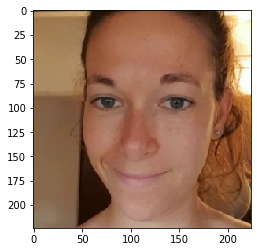

In [26]:
test_dir = "../Images/test_pictures/"
img =  kimage.load_img(test_dir+"alinda/alinda_120.png", target_size=(224, 224))

plt.imshow(img)
plt.show()

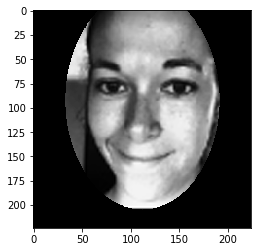

In [27]:
plt.imshow(simple_preprocessing(kimage.img_to_array(img)), cmap="gray")
plt.show()

Compute the features with each model:

In [28]:
%%time
mobilenet_query_features = compute_features(img, mobilenet_model, mobilenet_preprocessing)
densenet_query_features = compute_features(img, densenet_model, densenet_preprocessing)
simple_query_features = compute_features(kimage.img_to_array(img), simple_model, simple_preprocessing)
maxpool_query_features = compute_features(kimage.img_to_array(img), maxpool_model, simple_preprocessing)
doublesteps_query_features = compute_features(kimage.img_to_array(img), doublesteps_model, simple_preprocessing)

CPU times: user 2.43 s, sys: 2.89 s, total: 5.32 s
Wall time: 717 ms


Query the trees:

In [29]:
%%time
dist1, ind1 = mobilenet_tree.query(mobilenet_query_features.reshape(1, -1), k=10)
dist2, ind2 = densenet_tree.query(densenet_query_features.reshape(1, -1), k=10)
dist3, ind3 = simple_tree.query(simple_query_features.reshape(1, -1), k=10)
dist4, ind4 = maxpool_tree.query(maxpool_query_features.reshape(1, -1), k=10)
dist5, ind5 = doublesteps_tree.query(doublesteps_query_features.reshape(1, -1), k=10)

CPU times: user 11.5 ms, sys: 35.1 ms, total: 46.6 ms
Wall time: 6.67 ms


Plot the results:

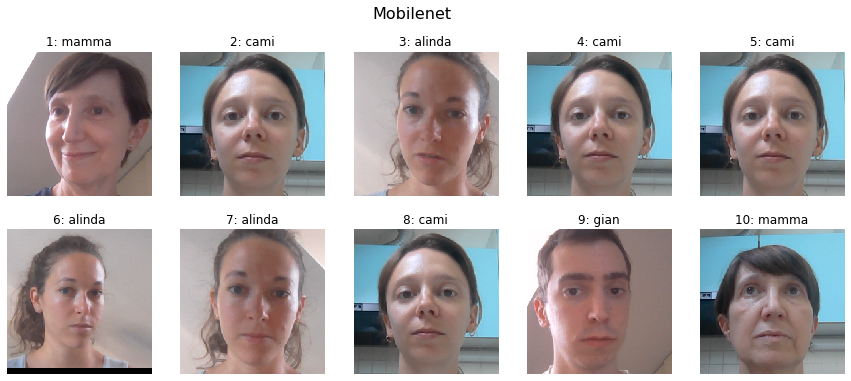

In [30]:
plot_imgs(paths, ind1, title = "Mobilenet")

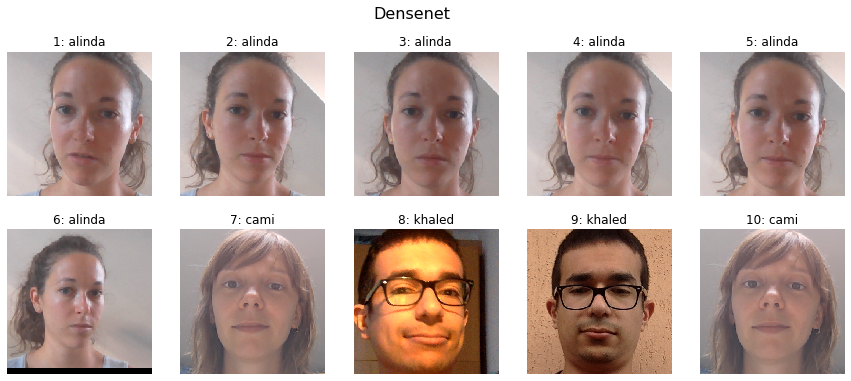

In [31]:
plot_imgs(paths, ind2, title = "Densenet")

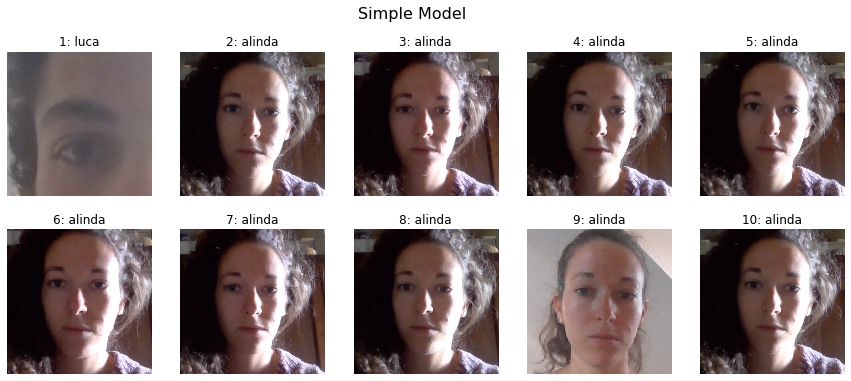

In [32]:
plot_imgs(paths, ind3, title="Simple Model")

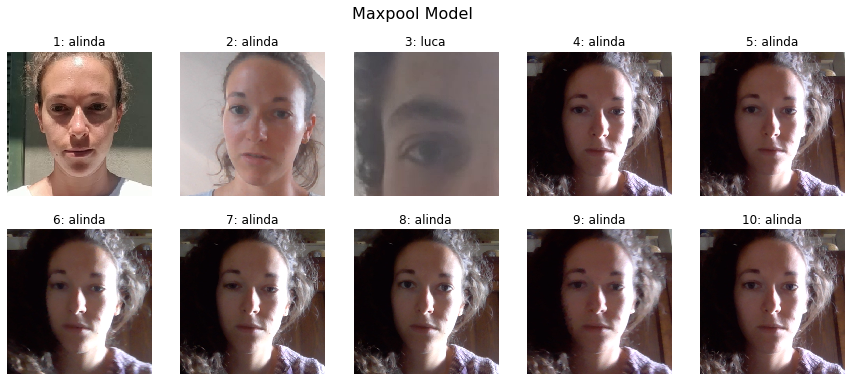

In [33]:
plot_imgs(paths, ind4, title="Maxpool Model")

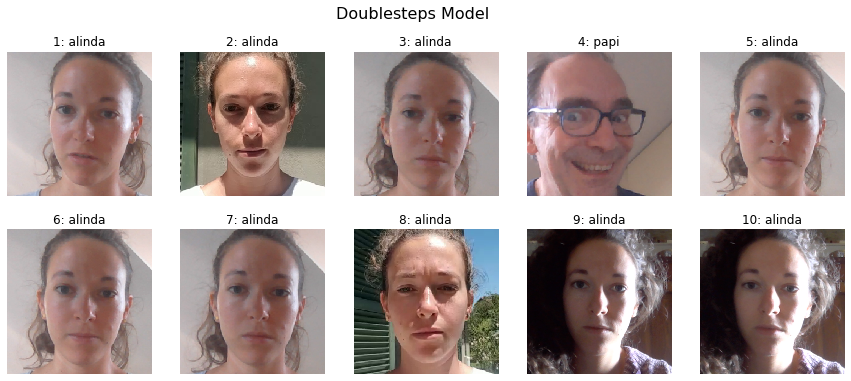

In [34]:
plot_imgs(paths, ind5, title="Doublesteps Model")

# Evaluation

Define functions for evaluation:

In [35]:
def evaluate_query_from_image(img, model, preprocess_fun, tree, true_class, k=10, plot = False):
    # print(true_class)
    query_features = compute_features(kimage.img_to_array(img), model, preprocess_fun)
    dist, ind = tree.query(query_features.reshape(1, -1), k=k)
    predicted = np.array(paths)[ind[0]]
    predicted = [f.split("/")[-1].split("_")[0] for f in predicted]
    # print(predicted)
    preds = np.array(predicted) == true_class
    p10 = np.sum(preds)/len(preds)
    p5 = np.sum(preds[:5])/5
    p1 = predicted[0] == true_class
    if plot:
        plot_imgs(paths, ind)
    return p1, p5, p10

In [36]:
def evaluate_query_from_filename(filename, model, preprocess_fun, tree, k=10, paths = paths, plot=False):
    true_class = filename.split("/")[-1].split("_")[0]
    img = kimage.load_img(filename, target_size=(224, 224), color_mode = "rgb")
       
    p1, p5, p10 = evaluate_query_from_image(img, model, preprocess_fun, tree, true_class, k=k, plot=plot)
    
    return p1, p5, p10

Next:

- For each person we take 15 random query pictures.
- For each picture, for each tree/model, we are going to query for the most similar 10 pictures
- We compute the Precision@k metric
- We take the average Precision@k over every query picture for each model

In [37]:
np.random.seed(1)
test_dir = "../Images/test_pictures/"
queries_per_person = 15
random_queries = []
for cls in folders:
    cls_files = [test_dir+cls+"/"+ f for f in os.listdir(test_dir+cls)]
    random_cls_files = np.random.choice(cls_files, queries_per_person, replace=False)
    random_queries.extend(random_cls_files)

In [38]:
# img = kimage.load_img(random_queries[0], target_size=(224, 224), color_mode = "rgb")
# plt.imshow(img)
# plt.show()

In [39]:
models = [mobilenet_model, densenet_model, simple_model, maxpool_model, doublesteps_model]
trees = [mobilenet_tree, densenet_tree, simple_tree, maxpool_tree, doublesteps_tree]
funs = [mobilenet_preprocessing, densenet_preprocessing, simple_preprocessing,
        simple_preprocessing, simple_preprocessing]
names = ["mobilenet", "densenet", "simple", "maxpool", "doublesteps"]

In [40]:
%%time
ap = {}
k = 5
for i in range(5):
    ap[i] = {}
    ap[i][1] = []
    ap[i][5] = []
    ap[i][10] = []
for i in range(len(random_queries)):
    for j in range(5):
        p1, p5, p10 = evaluate_query_from_filename(random_queries[i], models[j],
                                              funs[j], trees[j], k = k)
        ap[j][1].append(p1)
        ap[j][5].append(p5)
        ap[j][10].append(p10)
    
    ipd.clear_output(wait=True)
    print("Query #{}/{}".format(i+1, len(random_queries)))
    for j in range(5):
        print("\n{:11s} Average P@{:2d}: {:.3f}".format( names[j], 1, np.mean(ap[j][1])))
        print("{:11s} Average P@{:2d}: {:.3f}".format( "", 5, np.mean(ap[j][5])))
        print("{:11s} Average P@{:2d}: {:.3f}".format( "", 10, np.mean(ap[j][10])))


Query #120/120

mobilenet   Average P@ 1: 0.575
            Average P@ 5: 0.533
            Average P@10: 0.533

densenet    Average P@ 1: 0.575
            Average P@ 5: 0.577
            Average P@10: 0.577

simple      Average P@ 1: 0.575
            Average P@ 5: 0.602
            Average P@10: 0.602

maxpool     Average P@ 1: 0.575
            Average P@ 5: 0.598
            Average P@10: 0.598

doublesteps Average P@ 1: 0.533
            Average P@ 5: 0.552
            Average P@10: 0.552
CPU times: user 5min 24s, sys: 7min 40s, total: 13min 5s
Wall time: 1min 40s
